In [10]:
import pandas as pd
import numpy as np

In [12]:
# --- PATHS & FLAGS ----------------------------------------------------
from pathlib import Path
import pandas as pd, requests, io

# Base URL of my GitHub repo (raw view)
BASE_URL = ("https://raw.githubusercontent.com/"
            "Eugine-Srb/Sales-Forecasting_2024-Project/main/")


DATA_PROC_URL = BASE_URL + "data/raw/"     # for imports

# Local fallback folders (never pushed)
EXPORT_DIR = Path("../scratch_outputs")
EXPORT_DIR.mkdir(exist_ok=True)

# Master switch — keep False unless *really* want to re-export
SAVE_OUTPUTS = False

In [18]:
def load_processed(name: str) -> pd.DataFrame:
    """Load a frozen CSV straight from GitHub raw URL."""
    url = DATA_PROC_URL + name
    return pd.read_csv(url, low_memory=False)

In [20]:
# Load the Product Sales dataset

df = load_processed("02_product_sales_data_raw.csv")

In [64]:
# Preview the first 10 rows
df.head(12)

,Date,Product,Units_Sold,Unit_Price
0,2019-01-01,Alpha,146.0,100.151629
1,2019-02-01,Alpha,144.0,120.196688
2,2019-03-01,Alpha,129.0,59.398194
3,2019-04-01,Alpha,136.0,96.559802
4,2019-05-01,Alpha,129.0,109.083326
5,2019-06-01,Alpha,86.0,132.260056
6,2019-07-01,Alpha,108.0,102.224326
7,2019-08-01,Alpha,NaN,112.289048
8,2019-09-01,Alpha,88.0,103.135463
9,2019-10-01,Alpha,108.0,122.609133


In [65]:
# Explore value distribution for key columns
df['Product'].value_counts().head()

Product
Alpha    60
Beta     60
Gamma    60
Delta    60
Name: count, dtype: int64

In [66]:
df['Date'].value_counts().head()

Date
2019-01-01    4
2019-02-01    4
2021-09-01    4
2021-10-01    4
2021-11-01    4
Name: count, dtype: int64

In [67]:
# Check for missing values
df.isna().sum()

Date           0
Product        0
Units_Sold    12
Unit_Price     0
dtype: int64

In [68]:
# Share of rows with Nan
df['Units_Sold'].isna().sum() / len(df)

0.05

In [69]:
# # Basic statistics for 'Units_Sold'
df['Units_Sold'].describe().round(2)

count    228.00
mean     120.00
std       15.77
min       85.00
25%      107.00
50%      119.00
75%      131.00
max      160.00
Name: Units_Sold, dtype: float64

In [70]:
# Inspect missing 'Units_Sold' values by date
df[df['Units_Sold'].isna()].sort_values(by='Date')

,Date,Product,Units_Sold,Unit_Price
186,2019-07-01,Delta,NaN,70.498430
7,2019-08-01,Alpha,NaN,112.289048
190,2019-11-01,Delta,NaN,84.181735
135,2020-04-01,Gamma,NaN,116.519722
17,2020-06-01,Alpha,NaN,51.439349
218,2022-03-01,Delta,NaN,104.190095
163,2022-08-01,Gamma,NaN,83.349917
167,2022-12-01,Gamma,NaN,99.836777
171,2023-04-01,Gamma,NaN,58.534967
232,2023-05-01,Delta,NaN,129.878324


In [71]:
# Count missing values in 'Units_Sold' by product
df.groupby('Product')['Units_Sold'].apply(lambda x: x.isna().sum())

Product
Alpha    2
Beta     1
Delta    5
Gamma    4
Name: Units_Sold, dtype: int64

In [72]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [73]:
# Extract month and year for further analysis and visualization
df['Month'] = df['Date'].dt.strftime('%b')
df['Year'] = df['Date'].dt.year

In [74]:
# Count missing 'Units_Sold' values by year
df.groupby('Year')['Units_Sold'].apply(lambda x : x.isna().sum())

Year
2019    3
2020    2
2021    0
2022    3
2023    4
Name: Units_Sold, dtype: int64

In [75]:
# Create a boolean mask to identify which rows originally had missing (NaN) values in the 'Units_Sold' column.
# This helps us later highlight which points were filled via interpolation.
missing_mask = df['Units_Sold'].isna()

In [76]:
# Make a copy of the original DataFrame to preserve its state before interpolation.
# Then, fill the missing 'Units_Sold' values using linear interpolation, applied within each product group.
# 'limit_direction="both"' ensures that interpolation works at the start or end of each group if needed.
df_interpolated = df.copy()
df_interpolated['Units_Sold'] = df.groupby('Product')['Units_Sold'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both'))

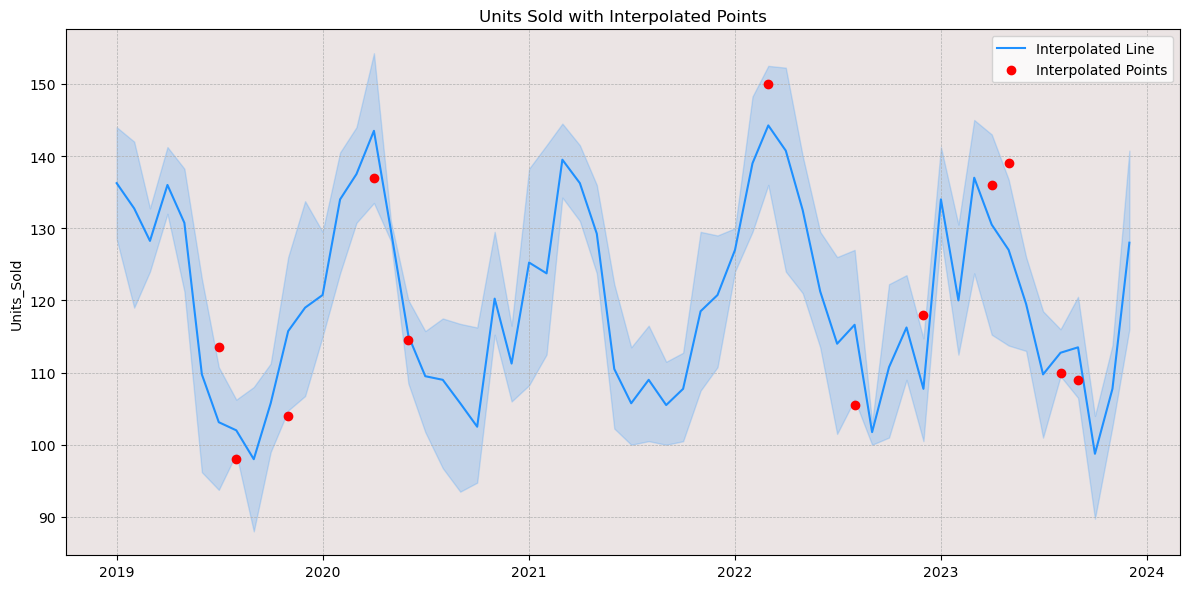

In [77]:
# Create a line chart of Units Sold over time after interpolation.
# Red points highlight where interpolation filled originally missing values.
# X-axis ticks are shown by year to avoid overcrowding.
# A light grey background enhances readability, and a dashed grid improves chart clarity.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df_interpolated, x='Date', y='Units_Sold', label='Interpolated Line', color='dodgerblue')

# Plot only interpolated points
plt.scatter(
    df_interpolated.loc[missing_mask, 'Date'],
    df_interpolated.loc[missing_mask, 'Units_Sold'],
    color='red',
    label='Interpolated Points',
    zorder=5
)

# X-axis ticks: Yearly
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

# Background
ax.set_facecolor('#ebe4e4')

# Styling
plt.grid(True, linestyle='--', linewidth=0.5)
plt.title("Units Sold with Interpolated Points")
plt.legend()
plt.xlabel('')
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# Compare the overall mean before and after interpolation to check how much the filled values affected dataset statistics
print("Original mean (with NaN):", df['Units_Sold'].mean())
print("Interpolated mean       :", df_interpolated['Units_Sold'].mean())
print("Relative difference (%):", (df_interpolated['Units_Sold'].mean() - df['Units_Sold'].mean()) / df_interpolated['Units_Sold'].mean() * 100)

Original mean (with NaN): 119.99561403508773
Interpolated mean       : 119.97291666666666
Relative difference (%): -0.018918743539532244


In [79]:
# Create a table showing where interpolation occurred:
# - 'Before' shows missing values (NaN)
# - 'After' shows interpolated values that replaced them
comparison = df.loc[missing_mask, ['Date', 'Product']].copy()
comparison['Before'] = np.nan
comparison['After'] = df_interpolated.loc[missing_mask, 'Units_Sold'].values
display(comparison)

,Date,Product,Before,After
7,2019-08-01,Alpha,NaN,98.0
17,2020-06-01,Alpha,NaN,114.5
115,2023-08-01,Beta,NaN,110.0
135,2020-04-01,Gamma,NaN,137.0
163,2022-08-01,Gamma,NaN,105.5
167,2022-12-01,Gamma,NaN,118.0
171,2023-04-01,Gamma,NaN,136.0
186,2019-07-01,Delta,NaN,113.5
190,2019-11-01,Delta,NaN,104.0
218,2022-03-01,Delta,NaN,150.0


In [80]:
df[df['Units_Sold'].isna()][['Date', 'Product']]

,Date,Product
7,2019-08-01,Alpha
17,2020-06-01,Alpha
115,2023-08-01,Beta
135,2020-04-01,Gamma
163,2022-08-01,Gamma
167,2022-12-01,Gamma
171,2023-04-01,Gamma
186,2019-07-01,Delta
190,2019-11-01,Delta
218,2022-03-01,Delta


In [81]:
# Create a report of missing values for transparency
Product_Sales_Missing_Report = df[df['Units_Sold'].isna()][['Date', 'Product']]
Product_Sales_Missing_Report['Imputed'] = True

In [82]:
Product_Sales_Missing_Report.value_counts()

Date        Product  Imputed
2019-07-01  Delta    True       1
2019-08-01  Alpha    True       1
2019-11-01  Delta    True       1
2020-04-01  Gamma    True       1
2020-06-01  Alpha    True       1
2022-03-01  Delta    True       1
2022-08-01  Gamma    True       1
2022-12-01  Gamma    True       1
2023-04-01  Gamma    True       1
2023-05-01  Delta    True       1
2023-08-01  Beta     True       1
2023-09-01  Delta    True       1
Name: count, dtype: int64

In [83]:
Product_Sales_Missing_Report.value_counts().count()

12

In [84]:
# Verify that all NaN values have been handled
df_interpolated.isna().sum()

Date          0
Product       0
Units_Sold    0
Unit_Price    0
Month         0
Year          0
dtype: int64

In [85]:
# Compute total revenue per row
df_interpolated['Revenue'] = df_interpolated['Units_Sold'] * df_interpolated['Unit_Price']

In [86]:
# Set flag to actual boolean type
df_interpolated['Interpolated_Flag'] = df['Units_Sold'].isna()

In [87]:
df_interpolated['Interpolated_Flag'] = df_interpolated['Interpolated_Flag'].astype(bool)

In [88]:
# Preview the updated dataset
df_interpolated.head(8)

,Date,Product,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag
0,2019-01-01,Alpha,146.0,100.151629,Jan,2019,14622.137902,False
1,2019-02-01,Alpha,144.0,120.196688,Feb,2019,17308.323033,False
2,2019-03-01,Alpha,129.0,59.398194,Mar,2019,7662.367024,False
3,2019-04-01,Alpha,136.0,96.559802,Apr,2019,13132.133047,False
4,2019-05-01,Alpha,129.0,109.083326,May,2019,14071.749061,False
5,2019-06-01,Alpha,86.0,132.260056,Jun,2019,11374.364822,False
6,2019-07-01,Alpha,108.0,102.224326,Jul,2019,11040.227209,False
7,2019-08-01,Alpha,98.0,112.289048,Aug,2019,11004.326663,True


In [ ]:
def maybe_save(df: pd.DataFrame, filename: str):
    """
    Save to scratch_outputs/ only if SAVE_OUTPUTS is True.
    Prevents overwriting the canonical CSVs in data/processed/.
    """
    if SAVE_OUTPUTS:
        df.to_csv(EXPORT_DIR / filename, index=False)
        print(f"🔸 Saved {filename} to {EXPORT_DIR}")
    else:
        print(f"⏩ Skipped saving {filename} (SAVE_OUTPUTS = False)")

In [ ]:
# Save the cleaned and enriched dataset for further use (e.g., Power BI or next analysis steps)
maybe_save(df_interpolated, "03-product_sales_interpolated_data.csv")

In [ ]:
# Save the table highlighting interpolated points
maybe_save(comparison, "04-product_sales_interpolation_points.csv")